In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
df = pd.read_csv('/content/breast-cancer.csv')

In [4]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
df.drop('id', axis=1, inplace=True) 

In [6]:
df['diagnosis'] = (df['diagnosis'] == 'M').astype(int)

In [7]:
corr = df.corr()

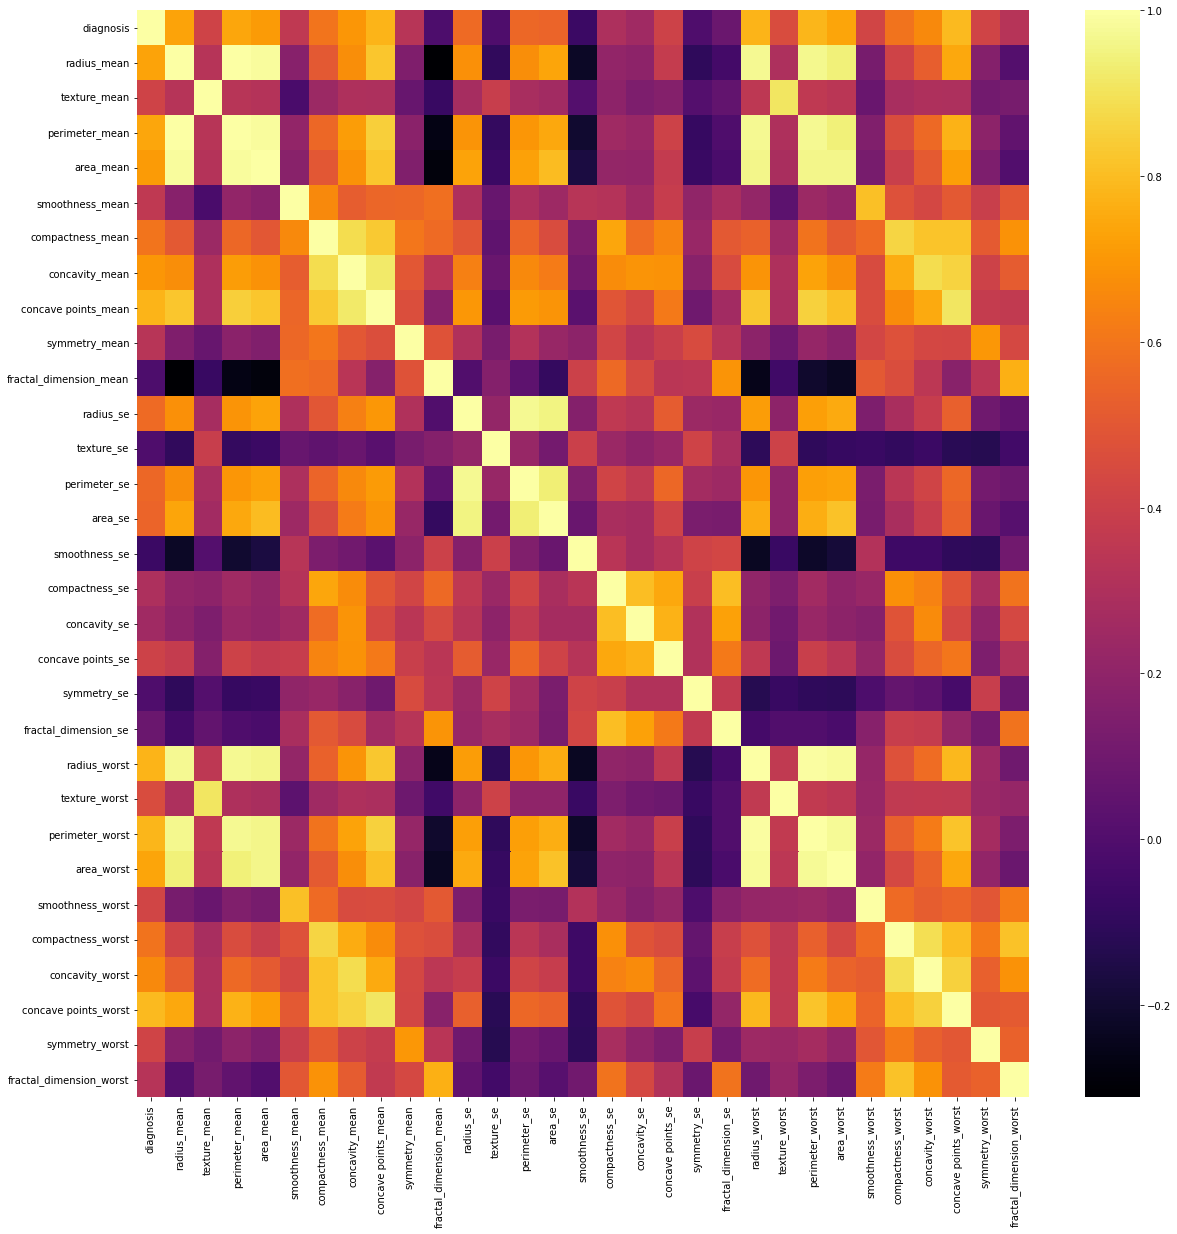

In [8]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap='inferno')
plt.show()

In [9]:
# Get the absolute value of the correlation
cor_target = abs(corr["diagnosis"])

# Select highly correlated features (thresold = 0.2)
relevant_features = cor_target[cor_target>0.2]

# Collect the names of the features
names = [index for index, value in relevant_features.iteritems()]

# Drop the target variable from the results
names.remove('diagnosis')

# Display the results
print(names)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'radius_se', 'perimeter_se', 'area_se', 'compactness_se', 'concavity_se', 'concave points_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [10]:
X = df[names].values
y = df['diagnosis'].values

In [11]:
def plot(X, y):
    plt.figure(figsize=(12,12))
    positive = y == 1
    negative = y == 0
    plt.plot(X[positive, 0], X[positive, 1], 'bo')
    plt.plot(X[negative, 0], X[negative, 1], 'ro')
    plt.show()

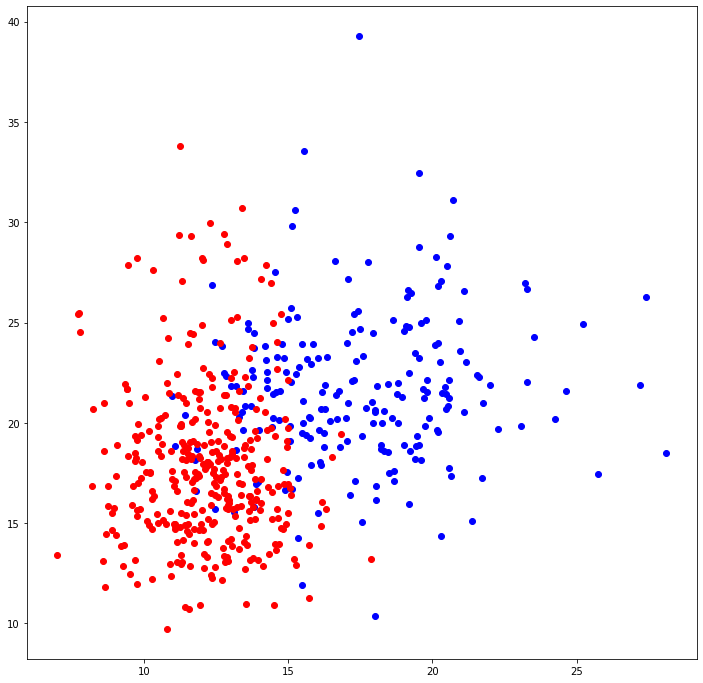

In [12]:
plot(X, y)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #create an instance of standard scaler
X = scaler.fit_transform(X) # fit it to the training data

In [14]:
def sigmoid(z):
    sigmoid = 1 / (1 + np.exp(-z))
    return sigmoid

In [15]:
z = np.linspace(-12, 12, 200)
fig = px.line(x=z, y=sigmoid(z),title='Logistic Function',template="plotly_dark")
fig.update_layout(
    title_font_color="#41BEE9", 
    xaxis=dict(color="#41BEE9"), 
    yaxis=dict(color="#41BEE9") 
)
fig.show()

In [16]:
def predict(X, y, W, b):
    Z = np.matmul(X, W) + b
    A = sigmoid(Z)
    return A

In [17]:
def compute_cost(X, y, W, b):
    m = X.shape[0]  # number of training exampeles
    predictions = predict(X, y, W, b) # get predictions
    
    #compute the cost
    cost = np.sum( (-np.log(predictions + 1e-8) * y) + (-np.log(1-predictions + 1e-8))*(1 - y) )# we are adding small value epsilon to avoid log of 0
    cost = cost / m
    return cost

In [18]:
def compute_gradient(X, y, W, b):
    #get training shape
    m = X.shape[0]
    
    #compute predictions
    predictions = predict(X, y, W, b)
    
    #compute gradients
    dW = np.matmul(X.T, (predictions-y))
    dW = np.array([np.mean(grad) for grad in dW])
    
    db = np.sum(np.subtract(predictions,y))
    
    #scale gradients
    dW = dW * 1/m
    db = db * 1/m
    
    
    return db, dW

In [19]:
def train(X, y, W, b, iterations, alpha): 
    costs = []
    for i in range(iterations):
        
        # Calculate the gradient and update the parameters
        db, dW = compute_gradient(X, y, W, b)   
        
        # Update Parameters using w, b, alpha and gradient
        b = b - alpha * db             
        W = W - alpha * dW               
       
        if i<100000:      # prevent resource exhaustion 
            cost =  compute_cost(X, y, W, b)
            costs.append(cost)
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(iterations/10) == 0 or i == (iterations-1):
            print(f"Iteration {i:4}: Cost {float(costs[-1]):8.2f}   ")
        return W, b,costs

In [20]:
np.random.seed(1)
intial_w = np.zeros(X.shape[1])
initial_b = 0.

# Some gradient descent settings
iterations = 80000
alpha = 0.0001

w, b, costs = train(X,y,intial_w, initial_b, iterations, alpha)

Iteration    0: Cost     0.69   


In [21]:
fig = px.line(y=costs,title="Cost vs Iteration",template="plotly_dark")
fig.update_layout(
    title_font_color="#41BEE9", 
    xaxis=dict(color="#41BEE9",title="Iterations"), 
    yaxis=dict(color="#41BEE9",title="cost")
) 

fig.show()